Rappels

[GO ontology](https://www.ebi.ac.uk/QuickGO/)

##### IFB Virtual Machine Configuration

* `rootDir` points to Jupyter Home Directory
* `projectDir` points to the Git project, holds the *tsv* file
* `libDir` points to Git project python library with files names `go.py  stat_utils.py  uniprot.py`
* `dataDir` points to shared data folder with uniprot and GO files

In [8]:
import sys

rootDir = "//ifb/data/mydatalocal"
projectDir = rootDir + "/VDB_jupyter"
libDir = projectDir + "/lib"
dataDir= "/ifb/data/public/teachdata/m2binf_ucbl/data" 
 

sys.path.append(libDir)
print(sys.path)

['/mnt/VDB_jupyter', '/opt/conda/lib/python37.zip', '/opt/conda/lib/python3.7', '/opt/conda/lib/python3.7/lib-dynload', '', '/opt/conda/lib/python3.7/site-packages', '/opt/conda/lib/python3.7/site-packages/IPython/extensions', '/home/jovyan/.ipython', '//ifb/data/mydatalocal/VDBscratch/lib', '//ifb/data/mydatalocal/VDBscratch/lib', '//ifb/data/mydatalocal/VDB_Jupyter/lib', '//ifb/data/mydatalocal/VDB_Jupyter/lib', '//ifb/data/mydatalocal/VDB_Jupyter/lib', '//ifb/data/mydatalocal/VDB_jupyter/lib']


In [9]:
import pandas, uniprot, go
import numpy as np
from stat_utils import computeORA_BKG

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt


## Jeux de données
* Experimental dataset as TSV
* Go ontology as [owl](http://www.obofoundry.org/ontology/go.html)
* Uniprot entries as XML files

## Objectifs
1. Lire et traiter des données d'entrée avec [PANDAS](https://pandas.pydata.org/)

2. Représenter la distribution empirique des "fold-change" (**FC**)

3. Evaluer un seuil de **FDR** 5%, with normal approximation
    1. Proposer une function qui à un seuil de faux-positif retourne une valeur de **FDC**
    2. Proposer une fonction qui appelle la précedente et retourne, en plus, une représentation graphique

4. Analyse de l'enrichissement en pathway Gene Ontology
    1. Arbre des termes d'ontologie.
        * Visualisation de l'arbre complet
    2. Modélisation hypergéometrique des fréquence attendues des termes GO
        * Les protéines très abondantes présentent-elles des termes GO en quantité remarquable ?
        * Les protéines peu abondantes présentent-elles des termes GO en quantité remarquable ?
    3. Visualisation de l'arbre avec style des noeuds rendant compte des protéines qu'ils annotent
 
5. Volcano plot
    1. Scatter-Plot **FC** vs **LOG10 Adj.P-val**
    2. Colorer les protéines très/peu abondantes
    3. ipyWidget slider FDR permettant de changer les seuils "d'abondance" 
    
6. Volcano Plot présentant les pathways
    1. ipyWidget Slider
    2. Coloration des points pour les protéines annotées par ce pathway 

## Conclusion
* Compare wt/mutant conditions


## Ressources
https://www.bioconductor.org/help/course-materials/2015/SeattleApr2015/E_GeneSetEnrichment.html

https://matplotlib.org/gallery.html#




## Format des données expérimentales

Le terme *SA*, désigne le ratio de (**S**ur) **A**bondance pour une protéines entre deux experiences.
Les valeurs de **SA** sont stockées dans la colonne ```Log2 Corrected Abundance Ratio```. Un "ratio" négatif indique qu'une protéine est moins présente dans l'experience considéré par rapport à une experience de référence.

* La condition experimentale de référence est un milieu de croissance bactérienne
* La condition experimentale testée est un milieu riche en Tétracycline 



# Première exploration des données

### Lecture des valeurs experimentales
Charger ```TCL_wt1.tsv``` dans une [dataframe pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html).
* Retirer les lignes présentant des aberrations numériques

##### [Comment filtrer des lignes Pandas](https://cmdlinetips.com/2018/02/how-to-subset-pandas-dataframe-based-on-values-of-a-column/)

In [40]:
import pandas
df=pandas.read_csv(projectDir + "/TCL_wt1.tsv", delimiter ="\t")
df.head()

,Accession,Description,Gene Symbol,Corrected Abundance ratio (1.53),Log2 Corrected Abundance Ratio,Abundance Ratio Adj. P-Value: (127. T3 Tc WT) / (126. T0 WT),LOG10 Adj.P-val
0,P75936,Basal-body rod modification protein FlgD OS=Es...,flgD,0.075816993,-3.721334942,0.000055,4.260067469
1,P76231,Uncharacterized protein YeaC OS=Escherichia co...,yeaC,0.092810458,-3.429568818,0.000351,3.45462743
2,P0A8S9,Flagellar transcriptional regulator FlhD OS=Es...,flhD,0.102614379,-3.284695189,0.000027,4.571899347
3,P0CE48,Elongation factor Tu 2 OS=Escherichia coli (st...,tufB,#VALEUR!,#VALEUR!,NaN,#VALEUR!
4,P05706,PTS system glucitol/sorbitol-specific EIIA com...,srlB,0.108496732,-3.204276506,0.019963,1.699767669


In [43]:
cleared_df = df.dropna()
cleared_df.shape

(1746, 7)

*1746 rows remained from 2024 after removal of missing values*

In [56]:
cleared_df.head()
cleared_df.reset_index(drop=True)

,Accession,Description,Gene Symbol,Corrected Abundance ratio (1.53),Log2 Corrected Abundance Ratio,Abundance Ratio Adj. P-Value: (127. T3 Tc WT) / (126. T0 WT),LOG10 Adj.P-val
0,P75936,Basal-body rod modification protein FlgD OS=Es...,flgD,0.075816993,-3.721334942,5.494560e-05,4.260067469
1,P76231,Uncharacterized protein YeaC OS=Escherichia co...,yeaC,0.092810458,-3.429568818,3.510530e-04,3.45462743
2,P0A8S9,Flagellar transcriptional regulator FlhD OS=Es...,flhD,0.102614379,-3.284695189,2.679790e-05,4.571899347
3,P05706,PTS system glucitol/sorbitol-specific EIIA com...,srlB,0.108496732,-3.204276506,1.996330e-02,1.699767669
4,P29744,Flagellar hook-associated protein 3 OS=Escheri...,flgL,0.124183007,-3.009460329,3.674628e-02,1.434786589
5,P0A9A2,Bacterial non-heme ferritin-like protein OS=Es...,ftnB,0.126797386,-2.979403095,1.296589e-03,2.887197633
6,P75937,Flagellar hook protein FlgE OS=Escherichia col...,flgE,0.137908497,-2.858216749,7.012880e-07,6.154103778
7,P43533,Flagella synthesis protein FlgN OS=Escherichia...,flgN,0.150326797,-2.733825887,1.322797e-03,2.878506676
8,P0ABR1,DNA damage-inducible protein I OS=Escherichia ...,dinI,0.159477124,-2.6485786,4.689497e-01,0.328873724
9,P26608,Flagellar secretion chaperone FliS OS=Escheric...,fliS,0.162091503,-2.625119627,5.282561e-01,0.277155457


### Visualisation de la distribution empirique
Représenter la distribution des **SA** de l'experience.
* [matplotlib histogramme](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.hist.html)
* implémenter ce graphique dans une fonction 
```python 
    def empirical(data:pandas.Series, bins:Number) -> (fig,ax)
```
##### [API des colonnes pandas](https://pandas.pydata.org/pandas-docs/version/0.24/reference/series.html)

#### Pour aller plus loin
Réaliser une Kernel Density Estimation sur un histogramme matplotlib doit être fait à l'aide du package scipy.
Heureusement le package seaborn propose une macro pour cela.

`seaborn.kdeplot(np.array(data), bw=0.5)`
* implémenter ce graphique dans une fonction 
```python 
    def empiricalKDE(data:pandas.Series, bins:Number, bandwidth:Number) -> (fig,ax)
```

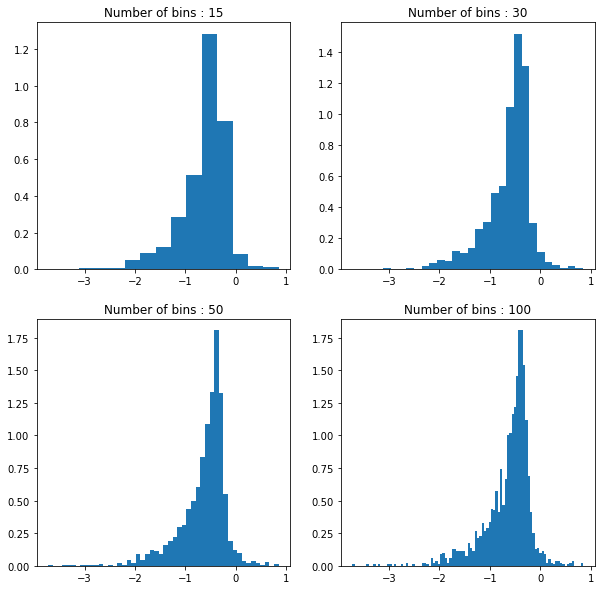

(<Figure size 540x540 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f53bfa539b0>)

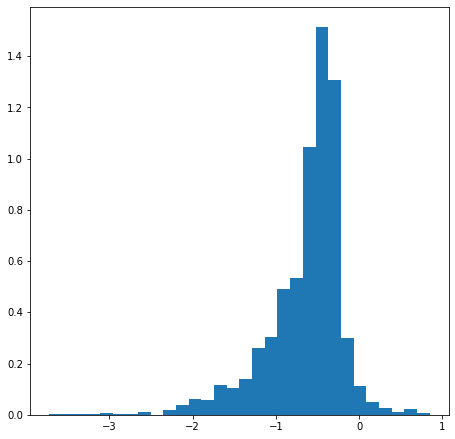

In [107]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# plt.hist(cleared_df[cleared_df.columns[3]], width=20)
# plt.show()

def categories(data): 
    bins=[15,30,50,100]
    i=0
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize= (10,10))
    for axe in axes: 
        for ax in axe: 
            ax.hist(data, int(bins[i]), density=True)
            ax.set_title("Number of bins : " + str(bins[i]))
            i+=1
    
    plt.show()
    return (fig,axes)
    
def empirical(data,bins): 
    fig, ax = plt.subplots(1, 1, figsize=(7.5, 7.5))
    ax.hist(data, int(bins), density=True)
    plt.show
    return (fig,ax)
logs=[float(x) for x in cleared_df[cleared_df.columns[4]].tolist()]
categories(logs)
empirical(logs,30)


### Distribution théorique attendue
Entre deux experiences, les quantités d'une protéine non affectée par le changement de conditions devraient-elles être strictement identiques ?

Proposer une distribution théorique des **SA** des protéines **non affectées** par le changement de conditions.
 * Calculer les paramètres de cette distribution à partir de l'échantillon
 * Représenter ces paramètres par des lignes verticales sur l'histogramme précedent

Implémenter une fonction qui prend un échantillon et **dessine** la distribution théorique et empirique. Elle utilisera la fonction ```empirical()```

```python 
    def empiricalAndTheoric(data:pandas.Series)
```

##### Pour aller plus loin
Vous dessinerez les histogrammes avec le paramètre `density=True` pour avoir une surface d'histogramme égale à 1. Ainsi l'aire de la fonction de densité étant égale à 1 les deux seront comparables sur le même graphique.
Si vous souhaitez garde la même échelle il faudra appliquer un échelle à la densité de probabilité (largeur de l'histogramme * nombre d'observation)


Exemple
```python
arr = np.random.randn(1000)

plt.figure(1)
result = plt.hist(arr)
plt.xlim((min(arr), max(arr)))

mean = np.mean(arr)
variance = np.var(arr)
sigma = np.sqrt(variance)
x = np.linspace(min(arr), max(arr), 100)
dx = result[1][1] - result[1][0]
scale = len(arr)*dx
plt.plot(x, norm.pdf(x, mean, sigma)*scale)

plt.show()

print(result)
print(result[1][1])
print(result[1][0])
```



-0.63862621564433
0.47062451611275274


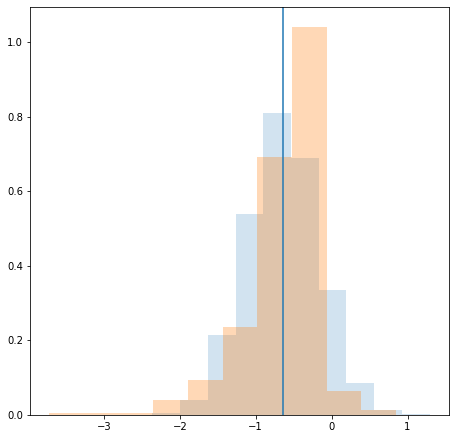

In [128]:
np.arange(min(logs),max(logs), 500)
mu=np.mean(logs)
print(mu)
sigma=np.std(logs)
print(sigma)
fake_x = np.random.randn(10000) * sigma + mu

fig, ax = plt.subplots(1, 1, figsize=(7.5, 7.5))
ax.hist(fake_x, alpha=0.2, density=True)
ax.hist(logs, density=True, alpha=0.3)
ax.axvline(mu)



### Seuil de significativité
Comment déterminer un seuil de *SA* au delà duquel seulement 5% des protéines **non affectées** seraient selectionnées ?

Pour une Méthode de reconnaissance des protéines sur abondantes que siginifie ce taux de 5% ?

Implémenter une fonction qui prend un échantillon et un pourcentage en argument et retourne la valeur seuil correspondant à cet argument.

```python 
    def FDR_threshold(data:pandas.Series, t=0.05) -> Number# Où t peut valoir 5%, 2.5% ou 1%
```

Creer la fonction suivante

```python
def empiricalAndTheoricTreshold(data:pandas.Series, t=0.05)
```

Elle combinera les fonctions ```FDR_threshold``` et ```empiricalAndTheoric``` pour ajouter à son histogramme une ligne verticale rouge à l'emplacement du seuil.

Aide: L'inverse de la fonction de densité cumulée (aka: [percent-point-function](https://en.wikipedia.org/wiki/Quantile_function)) de la loi normale est [implémentée dans scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html) (**ppf**).



### Optionnel
##### Visualisation des seuils et de la distribution empirique
Implémenter une fonction qui prend un échantillon et dessine la distribution théorique, empirique et colore [l'aire sous la courbe](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.fill_between.html) théorique au delà du seuil demandé.
Vous pourrez ajouter les légendes correspondant à $\mu, 2\sigma, \tau$ 

```python 
    def empiricalAndTheoricThresholdArea(SA_list, parameters*)
```



### Pour aller plus loin

###### La loi normale est un modèle contestable ici
https://en.wikipedia.org/wiki/Cauchy_distribution


# Definitions de pathway fonctionels


Nous disposons d'un jeu de protéines caractérisées par

* Un ratio de quantification entre deux experiences
* Une fiche uniprot 

Par ailleurs, l'ontologie GO est disponible via
* un fichier plat de définition
* une librarie pour la manipuler

Il nous est demandé de detecter si certains termes GO sont fortement représentés parmi les protéines SurAbondantes.
Par la suite, on utilisera indifférement les termes **Pathway** et **annotation GO**.

### Evaluation théorique de l'abondance

* $Q+$ : Proteines Sur-représentées
* $\overline{Q+}$ : Proteines non Sur-représentées

* $PW^{a}$ : Nombre de protéines membres du Pathway$a$
* $\overline{PW^{a}}$ : Nombre de protéines non-membres du Pathway$a$



 Proteines | $Q+$  | $\overline{Q+}$ | Total lignes
 :--- | --- |--- |---|
membres de $PW^{a}$  | $PW^{a}_{Q+}$ | $PW^{a}_{\overline{Q+}}$ | $nPW^{a}$
non-membres de $PW_{a}$ | $\overline{PW^{a}}_{Q+}$ | $\overline{PW^{a}}_{\overline{Q+}}$ | $n\overline{PW^{a}}$
  **Total colonnes** | n$Q+$ | n$\overline{Q+}$ | **nTOT**
 
 
**Question**:"Le nombre de protéines sur-représentées dans le Pathway$a$ est-il grand comparé à ce qui serait attendu au hasard?"


<!--## Deprecated 
 **Question**:"Les protéines sur-représentées sont-elles plus fréquentes dans le Pathway$a$ que dans les protéines non-membre du Pathway$X$?"
 
L'hypothèse nulle est "Les protéines membres du pathway et non-membres du pathway ont des quantifications similaires".
 -->
        

### Modélisation du hasard par une loi hypergéométrique

Pour un pathway donné ($PWa$), chaque protéine sur-abondante peut être vue comme un tirage dans le pool de protéines de l'expérience. La population de ce pool est consituée de deux groupes:
 * Le groupe des protéines appartenant à $PWa$
 * Les autres ($\overline{PW^{a}}$)

La probabilité d'observer $k$ protéines de $PWa$ parmi les $n$ sur-abondantes se modélise alors naturellement par la loi de probabilité hypergéométrique.

Rappellez-vous,

Si X est la variable aléatoire du nombre de succès parmi n observations, sans remise.
Alors la probabilité d'oberver exactement $k$ succès, suit une loi hypergéométrique de paramètres $N, n$ et $k$

$P(X=k) = \frac{ {K\choose k} {N-K\choose n-k} } { {N\choose K} }$

où


* $K$ est le nombre de succès dans la population totale
* $n$ est le nombre d'observations
* $N$ est la taille de la population totale
* $k$ est le nombre de succès parmi les observations

Si **pour chaque $Pathway^{a}$**, $X$ est la variable aléatoire du **nombre de protéines sur-représentée** dans l'experience.


Cocher les relations correspondantes


  x  | $nTOT$ | $nPW^{a}_{Q+}$ | $nPW^{a}$ | $nQ+$
 --- | ---   | ---     | ---  | --- |
 $K$ |       |         |      | 
 $n$ |       |         |      | 
 $N$ |       |         |      | 
 $k$ |       |         |      | 
 
 
 
 
Rappel: $nPW^{a}_{Q+}$ est le nombre de protéines appartenant au $Pathway^{a}$ parmi les protéines surexprimées

Que représentent alors les deux expressions suivantes:

$ P(X=nPW^{a}_{Q+})= \frac{ {nPW^{a}\choose X} {n\overline{PW^{a}}\choose nQ^{+} - X} } { {nTOT\choose nPW^{a}} }$


$P(X >= PW^{a}_{Q+})  = \sum_{x_{i}=PW^{a}_{Q+}}^{x_{i} \le nQ+}\frac{ {nPW^{a}\choose x_{i}} {n\overline{PW^{a}}\choose nQ^{+} - x_{i}} } { {nTOT\choose nPW^{a}} }$


###### Créer la fonction qui retournera la probabilité, sous un [modèle hypergeométrique](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.hypergeom.html), d'obtenir $k$ succès ou plus,

```python
def righEnd_pValue(N, n, K, k) => p
```
Aux arguments:
* $N$, le nombre total d'objet
* $n$, le nombre de tirages
* $K$, le nombre total d'objet de *typeI*
* $k$, le nombre de tirage d'objet de *typeI* (ie: nombre de succès parmi les tirages)

##### Dessiner les lollipop charts de la densité de probabilité et de la densité cumulée de la loi

L'enrichissement en terme GO parmi les protéines surabondantes sera estimé par cette fonction, avec
* $N$, le nombre total de protéines annotées dans le protéome
* $n$, le nombre de protéines surabondantes
* $K$, le nombre de protéines annotées par ce terme GO dans le protéome
* $k$, le nombre de protéines annotées par ce terme GO dans les protéines surabondantes


### Prise en compte des annotations GO

##### Chargement des données uniprot et de l'ontologie GO

In [ ]:
uniprotCollection = uniprot.UniprotCollection(dataDir +"/dataset")
K12 = uniprot.UniprotCollection(dataDir + "/K12_proteome/")
print("Loading ontology")
go.setOntology(dataDir + "/go.owl")

### Manipulation de termes GO à l'aide de *go.py*

Règle du vrai chemin: *Si une protéine est porteuse d'un terme GO, alors est elle aussi porteuse de tous les parents de ce terme.*

#### AnnotationTree est l'arbre des annotations GO portées par une collection de proteines 

##### Un arbre ne rend compte que d'un seul namespace GO
On définit le namespace des termes GO à extraire par un de ces trois termes : 
* "biological process", "molecular function", "cellular component"
 
```python
aTree = go.AnnotationTree("biological process", collapse=True)
```
On ne garde dans cet arbre que les termes portés par les protéines données en dernier argument
```python
aTree.read_DAG(['P75936', 'P76231', 'P0A8S9'], uniprotCollection)
```

#### API de l'arbre d'annotations


##### Taille de l'abre
```python
aTree.dimensions
```

##### Extraire un sous arbre
```python
bTree = aTree.newRoot("transmembrane transport")
```

##### Enumerer les protéines porteuses de termes GO

###### Dans tout l'arbre
```python
proteinList = aTree.getMembers()
```
###### A partir d'un noeud
```python
proteinList = aTree.getMembersByName("transmembrane transport")
proteinList = aTree.getMembersByID("GO:0055085")
```

##### Acceder directement à un noeud
```python
goTerm = aTree.getByName("transmembrane transport")
goTerm = aTree.getByID("GO:0055085")
```

##### Elager un arbre
Retirer tous les noeuds n'ayant aucun des éléments suivants parmi leurs protéines annotées

```python
def predicat(goTerm):
    return set(goTerm.getMembers()) & set(['P75936', 'P76231', 'P0A8S9'])

bTree = aTree.drop(predicat)
```

### Evaluer la pValue d'enrichissment en terme GO d'une liste de protéine donnée

Avant d'appeler `righEnd_pValue`, on devra donc

1. Lister les protéines surabondantes
2. Lister toutes les protéines sous le terme GO de votre choix 
    1. dans l'experience
    2. dans le protéome
3. Calculer l'intersection entre *A* et *B*

###### *Aide:*
Vous vous aiderez 
- de l'API de `go.annotationTree` 
- des commandes [`set` de python](https://docs.python.org/3/library/stdtypes.html#set)
- du [filtrage de colonne Pandas](https://cmdlinetips.com/2018/02/how-to-subset-pandas-dataframe-based-on-values-of-a-column/) pour évaluer la liste de protéines surabondantes
- de la [fonction subplot de matplotlib](https://stackoverflow.com/questions/42818361/how-to-make-two-plots-side-by-side-using-python), pour dessiner les deux courbes cote-à-cote

Pour faciliter le travail nous prendrons le seuil de 0.0 pour detecter la surabondance d'une protéine

## Analyse de la surreprésentation

Le package *stat_utils.py* permet d'appliquer cette analyse récursivement, en profondeur, à partir d'un terme GO général.

#### Estimation récursive des enrichissements

* Choix du terme GO général
```python
pathWayRoot = xpGoTree.getByName("transmembrane transport")
```

* Définition du terme GO regroupant tout le protéome
```python
pathWayBKG = fullEcoliGoTree.getByName("biological process")
```

* Calcul de l'enrichissement en termes GO successifs parmi les protéines surabondantes (ici, *saList*)
```python
oraFisher, oraCDF = computeORA_BKG(pathWayRoot, saList, pathWayBKG)
```
* Des arbres peuvent également être passés.
```python
tm_transport_GoTree = xpGoTree.newRoot("transmembrane transport")
oraFisher, oraCDF = computeORA_BKG(tm_transport_GoTree, saList, fullEcoliGoTree)
```

#### Affichage des enrichissements
La fonction ci-dessous va vous permettre d'afficher les pathway par ordre croissant de p-value
```python
def printRankings(saList,_oraFisher, _oraCDF):
    fisherRanking = [ ( d[0], d[1].name, len( set(d[1].getMembers()) & set(saList) ), len(saList) ) for d in sorted(oraFisher, key=lambda x:x[0]) ]
    cdfRanking = [ ( d[0], d[1].name, len( set(d[1].getMembers()) & set(saList) ), len(saList) ) for d in sorted(oraCDF, key=lambda x:x[0]) ]
    print(f"FISHER test Rankings:\n{fisherRanking}")
    print('\n---\n')
    print(f"CDF Rankings:\n{cdfRanking}")
```

##### Intégration des résultats à la visualisation du notebook 

En vous inspirant de la fonction ci-dessus, proposer une classe `Rankings` implémentant une méthode [`_repr_html_`](https://ipython.readthedocs.io/en/stable/config/integrating.html) qui permette un affichage plus lisible des résultats, comme par exemple:

![caption](figs/_repr_html_.png)

#### Appliquer cette analyse à terme GO de votre choix (et tous ses fils)
 - Il serait souhaitable d'encapsuler les différentes étapes dans une fonction de ce type
```python
    def computePathway(goTermString, xpTreeTerm, bkgTreeTerm, uniprotIdList) -> oraFisher, oraCDF
```
#### Appliquer cette analyse à tous les termes GO à un des arbres "biological process", "molecular function", "cellular component"

***


## Visualisation des arbres
Nous allons maintenant représenter la hiérarchie des termes GO portés par les protéines surreprésentées.
Dans un premier temps, il vous est conseillé de vous placer à un niveau suffisamment bas dans l'arbre pour constuire la visualisation avec peu de feuilles.

##### Elagage de l'arboresence GO
Nous souhaitons, éliminer les branches de l'arbre ne comportant aucune protéine surreprésentées.
On peut facilement obtenir toutes les protéines sous un terme GO donné, via l'API de l'arbre ou du terme GO.
```python
# Recupere depuis l'arbre toutes les occurences de protéines sous le noeud "intracellular part"
proteinIdList = aTree.getMembersByNames("intracellular part")
# Recupere le noeud "intracellular part" depuis l'arbre, puis toutes les occurences de protéines sous celui-ci
GOterm = aTree.getByNames("intracellular part")
_proteinIdList = GOTerm.getMembers()
set(_proteinIdList) == set(proteinIdList) # -> True
```

L'API arbre fournit la méthode **drop**, qui prend en argument une fonction prédicat qui sera appliquée récursivement à chaque terme de l'arbre. 
* Le prédicat recoit un unique argument, le terme à évaluer.
* Le prédicat doit retourner un booléen. 
* Si le prédicat retourne faux, le noeud évalué (ainsi que son sous-arbre) sera supprimé ("droped")

### ete3

La librairie [ete3](http://etetoolkit.org/) est une solution rapide pour déssiner des arbres en Python. 
Son intégration à [Jupyter](http://etetoolkit.org/ipython_notebook/) va vous permettre de dessiner la hiérarchie de termes GO portées par les protéines surreprésentées. Libre à vous d'essayer les différents ["layout"](http://etetoolkit.org/docs/latest/tutorial/tutorial_drawing.html#circular-tree-in-180-degrees)

### amélioration

Vous observerez que les arbres de termes GO des études experimentales ont été modifiés lors de l'analyse d'enrichissement. Chacun de leurs noeuds sont desormais porteurs:
* d'une p-value d'enrichissement : `aTree.getByName("pore complex").Fisher`
* d'une liste de protéines effectivement annotées : `aTree.getByName("pore complex").eTag`

Les proteines annotées par ce terme ou ses descendants sont toujours accessibles: `set( aTree.getMembersByName("pore complex") )`

Vous pouvez rendre compte de ses valeurs en modifiant couleurs et tailles des noeuds correspondant dans la représentation graphique.

***

#### Visualisation des abondances et Pathway pour chaque protéine
Nous allons représenter la relation entre l'abondance des protéines (**Log2 Corrected Abundance Ratio**)  et la précision de la mesure (**LOG10 Adj.P-val**). Ceci se fera à l'aide de la commande matplotlibb [scatter](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.scatter.html).
###### Volcano Plot global
* Creer la fonction drawScatter(abundanceList, precisionList) qui produira le graphique.
* Creer la fonction drawScatterPathway(goTermsList) 
    * Unique argument qui est une liste n goTerm aux p-value les plus faibles.
    * Dessine les protéines annotées par ces termes GO
    * Colorie de la même couleur, les protéines du même pathway
    * Si une protéine appartient à différents pathway, la priorité ira à celui de p-value la plus faible.

Au maximum 20 pathways pourront être représentés simultanément, vous utiliserez les [cartes de couleurs catégorielles](https://matplotlib.org/examples/color/colormaps_reference.html)

######  Volcano Plot interactif

Il serait plus intéressant de colorier les protéines d'un pathway donné à la volée, en mettant à jour le scatter plot à chaque fois. Jupyter fournit une libraire de composant interactif appelés [widgets](https://ipywidgets.readthedocs.io/en/stable/user_guide.html). 

* Construisez un widget `Dropdown` listant les pathway.
